In [ ]:
#v1
%matplotlib inline
%matplotlib notebook
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interactive
import json
from datetime import datetime
import requests

#load the data
def load_and_preprocess_temp_data(file_path):
    with open(file_path) as f:
        data = json.load(f)
        values = [item['values'] for item in data[0]['data']]
        flat_values = [item for sublist in values for item in sublist]
        df = pd.DataFrame(flat_values)
        df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
        df.set_index('date', inplace = True)
        df['value'] = df['value'].astype(float)
        return df
    
hourly_data = load_and_preprocess_temp_data('737_TOBS_POR.json')
max_temp_data = load_and_preprocess_temp_data('737_TMAX_POR.json')

plt.figure(figsize = (15,7))

#plt.plot(hourly_data.index, hourly_data['value'], label = 'Hourly Temp (degF)', color = 'blue', alpha=0.5)
plt.plot(hourly_data.index, hourly_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(max_temp_data.index, max_temp_data['value'], label = 'Max Temp (degF)', color = 'orange', marker ='o', linestyle='None', markersize=5)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Unedited Hourly and Max Air Temp')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()
        

In [ ]:
#v2 Fixed Threshold
# Optimized cleaning function
def clean_max_temp_data(max_temp_data, hourly_data, acceptable_range=32):
    #hourly_data.index = pd.to_datetime(hourly_data.index.date)
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    #max_temp_data.index = pd.to_datetime(max_temp_data.index.date)
    daily_max_hourly = hourly_data.resample('D').max()
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_max', '_hourly_max'))
    merged_data['diff'] = (merged_data['value_max'] - merged_data['value_hourly_max']).abs()
    #cleaned_data = merged_data[merged_data['diff'] <= acceptable_range]
    merged_data.loc[merged_data['value_hourly_max'].isna() | (merged_data['diff'] > acceptable_range), 'value_max'] = pd.NA
    return merged_data[['value_max']]
    

# Clean the max temp data
hourly_data = load_and_preprocess_temp_data('737_TOBS_POR.json')
max_temp_data = load_and_preprocess_temp_data('737_TMAX_POR.json')
#cleaned_max_temp_data = clean_max_temp_data(max_temp_data, hourly_data)


cleaned_values_for_plotting = cleaned_max_temp_data['value_max'].replace([pd.NA, None], np.nan).astype(float)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_data.resample('D').max()['value'], 'o', color='blue', markersize=5, label='Hourly Temp (degF)')
plt.plot(cleaned_max_temp_data.index, cleaned_values_for_plotting, 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data at a Fixed Threshold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
cleaned_max_temp_data.to_csv('cleaned_max_temp_data.csv') 


In [ ]:
#CONCERNS: I DON'T EVEN TRUST THE HOURLY DATA OR RATHER THERE ARE 
#QUITE A FEW INCONSISTENCIES: NOT ALL HOURLY DATA IS LISTED FOR EACH DAY SO
#WILL NEED TO DETERMINE VALIDITY OF HOURLY DATA BY COMPARING NEIGHBORING VALUES
#AND COMPARE HISTORICAL TRENDS

In [ ]:
#v3 Dynamic Thresholding. Love that :>
#THRESHOLD: is calculated from the temperature data to identify and remove discrepancies between hourly max temps 
#& daily reported max temps. This Threshold is based on the difference between the max temps recorded in the hourly
#data and the daily maximum temps reported separately. 
#Steps: calc the daily max from the hourly temp data
#Steps: Compare calculated daily maximums with the separately reported daily maximums
#Steps: Lastly calc the abs diff between the two sets of maximums temps for each day
#Steps: The abs diff is used to identify, clean, and in some cases null data points
#
#
def clean_max_temp_data(max_temp_data, hourly_data):
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    #calculates the daily max from hourly
    daily_max_hourly = hourly_data.resample('D').max() 
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_max', '_hourly_max'))
    merged_data['diff'] = (merged_data['value_max'] - merged_data['value_hourly_max']).abs()
    mean_diff = merged_data['diff'].mean()
    std_diff = merged_data['diff'].std()
    threshold = mean_diff +2*std_diff
    print(f"Calculated threshold: {threshold}")
    #cleaned_data = merged_data[merged_data['diff'] <= acceptable_range]
    merged_data.loc[merged_data['diff'] > threshold, 'value_max'] = np.nan
    merged_data['threshold'] = threshold
    return merged_data[['value_max', 'threshold']]
    

# Clean the max temp data
hourly_data = load_and_preprocess_temp_data('737_TOBS_POR.json')
max_temp_data = load_and_preprocess_temp_data('737_TMAX_POR.json')
cleaned_max_temp_data_with_threshold = clean_max_temp_data(max_temp_data, hourly_data)


#cleaned_values_for_plotting = cleaned_max_temp_data['value_max'].replace([pd.NA, None], np.nan).astype(float)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_data.resample('D').max().index, hourly_data.resample('D').max()['value'] , 'o', color='blue', markersize=5, label='Hourly Temp (degF)')
plt.plot(cleaned_max_temp_data_with_threshold.index, cleaned_max_temp_data_with_threshold['value_max'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data with Dynamic Thresholding')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
cleaned_max_temp_data_with_threshold.to_csv('cleaned_max_temp_data.csv') 


In [ ]:
#v4 Applied a decision based logic based on dynamically calculated thresholds. Three data options: null, correct and verify.
#Concerns: Some max data cannot be verified due to data gaps in hourly data so if value is not verfied than highest value is
#nulled or corrected with highest hourly value. If we are going to rely on hourly data then we better have certainty in validity
#Might need to shift focus into hourly data and clean that up first..is this a rabbit hole or useful qaqc? -question for DCO
#Also need to correct values that were nulled and were correct

def clean_max_temp_data(max_temp_data, hourly_data, acceptable_range=10.0):
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    daily_max_hourly = hourly_data.resample('D').max()
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_reported', '_calculated'))
    merged_data['diff'] = (merged_data['value_reported'] - merged_data['value_calculated']).abs()
    #Decide on handling based on threshold:
    merged_data['status'] = np.where(merged_data['diff'] <= acceptable_range, "Verfied", "Corrected")
    merged_data['value_final'] = np.where(merged_data['diff'] <= acceptable_range, merged_data['value_reported'], merged_data['value_calculated'])
    
    return merged_data[['value_calculated', 'value_reported', 'value_final', 'status']]
    

# Clean the max temp data
hourly_data = load_and_preprocess_temp_data('737_TOBS_POR.json')
max_temp_data = load_and_preprocess_temp_data('737_TMAX_POR.json')
#cleaned_max_temp_data = clean_max_temp_data(max_temp_data, hourly_data)


cleaned_data = clean_max_temp_data(max_temp_data, hourly_data)


# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_data.index, hourly_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(cleaned_data.index, cleaned_data['value_calculated'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data Using Decision Based Logic and Dynamic Thresholding')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
cleaned_data.to_csv('cleaned_max_temp_data.csv') 

In [ ]:
#v4 copy no changes yet.
#Looking ahead: "automatically" query soap page daily (or at whatever desired intervals), download data, and apply automatic
#cleanup and qaqc. The upload process via DMP is time consuming and manual tho
#NEW GOAL: DATA FETCH. WORK SMARTER NOT HARDER..so I can go ski ;>
#Test Section:


def clean_max_temp_data(max_temp_data, hourly_data, acceptable_range=10.0):
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    daily_max_hourly = hourly_data.resample('D').max()
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_reported', '_calculated'))
    merged_data['diff'] = (merged_data['value_reported'] - merged_data['value_calculated']).abs()
    #Decide on handling based on threshold:
    merged_data['status'] = np.where(merged_data['diff'] <= acceptable_range, "Verfied", "Corrected")
    merged_data['value_final'] = np.where(merged_data['diff'] <= acceptable_range, merged_data['value_reported'], merged_data['value_calculated'])
    
    return merged_data[['value_calculated', 'value_reported', 'value_final', 'status']]
    

# Clean the max temp data
hourly_data = load_and_preprocess_temp_data('737_TOBS_POR.json')
max_temp_data = load_and_preprocess_temp_data('737_TMAX_POR.json')
#cleaned_max_temp_data = clean_max_temp_data(max_temp_data, hourly_data)


cleaned_data = clean_max_temp_data(max_temp_data, hourly_data)


# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_data.index, hourly_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(cleaned_data.index, cleaned_data['value_calculated'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
cleaned_data.to_csv('cleaned_max_temp_data.csv') 

<IPython.core.display.Javascript object>


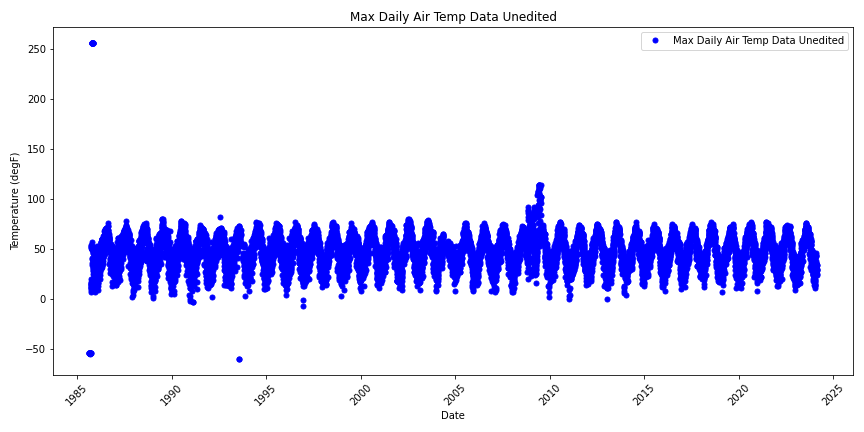

In [2]:
#v5 #DATA FETCH. Cleaning not applied.
%matplotlib inline
%matplotlib notebook
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from ipywidgets import interactive
import json
from datetime import datetime
import requests
#DATA FETCH
base_url = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"
params = {
    "stationTriplets": "737:CO:SNTL",
    "beginDate": "1984-10-01 00:00",
    "endDate": "2024-02-15 00:00",
    "duration": "DAILY",
    "elements": "TMAX:*:1",
    "centralTendencyType": "NONE"
}
    
response = requests.get(base_url, params=params)

if response.status_code == 200:
    try:
        data = response.json()
        values = [item['values'] for item in data[0]['data']]
        flat_values = [item for sublist in values for item in sublist]
        df = pd.DataFrame(flat_values)
    except ValueError as e:
        print(f"Error: {response.status_code}")


df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
df.set_index('date', inplace = True)
df['value'] = df['value'].astype(float)


plt.figure(figsize=(12,6))
plt.plot(df.index, df['value'], marker='o', linestyle='None', color='blue', markersize=5, label="Max Daily Air Temp Data Unedited")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Max Daily Air Temp Data Unedited')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
#TESTING SECTION
def fetch_awdb_data(station_triplets, begin_date, end_date, elements, duration):
    base_url = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/data"
    params = {
        "stationTriplets": station_triplets,
        "beginDate": begin_date,
        "endDate": end_date,
        "duration": duration,
        "elements": elements,
        "centralTendencyType": "NONE"
    }
    
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        try:
            data = response.json()
            values = [item['values'] for item in data[0]['data']]
            flat_values = [item for sublist in values for item in sublist]
            df = pd.DataFrame(flat_values)
        except ValueError as e:
            print(f"Error: {response.status_code}")
       
def clean_max_temp_data(max_temp_data, hourly_data, acceptable_range=10.0):
    hourly_data.index = pd.to_datetime(hourly_data.index).normalize()
    daily_max_hourly = hourly_data.resample('D').max()
    merged_data = pd.merge(max_temp_data, daily_max_hourly, left_index=True, right_index=True, how='left', suffixes=('_reported', '_calculated'))
    merged_data['diff'] = (merged_data['value_reported'] - merged_data['value_calculated']).abs()
    #Decide on handling based on threshold:
    merged_data['status'] = np.where(merged_data['diff'] <= acceptable_range, "Verfied", "Corrected")
    merged_data['value_final'] = np.where(merged_data['diff'] <= acceptable_range, merged_data['value_reported'], merged_data['value_calculated'])
    
    return merged_data[['value_calculated', 'value_reported', 'value_final', 'status']]

station_triplets ="737:CO:SNTL"
begin_date = "1984-10-01 00:00"
end_date = "2024-02-16 00:00"

tobs_data_json = fetch_awdb_data(station_triplets, begin_date, end_date, "TOBS:*:1", "HOURLY")
tmax_data_json = fetch_awdb_data(station_triplets, begin_date, end_date, "TMAX:*:1", "DAILY")

#convert json data fetch to df
tobs_data = pd.DataFrame([item for sublist in tobs_data_json[0]['data'] for item in sublist['values']])
tmax_data = pd.DataFrame([item for sublist in tmax_data_json[0]['data'] for item in sublist['values']])

#convert date columns and set as index
for df in [tobs_data, tmax_data]:
    df['date'] = pd.to_datetime(df['date'], errors = 'coerce')
    df.set_index('date', inplace = True)
    df['value'] = df['value'].astype(float)

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(tobs_data.index, tobs_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(tmax_data.index, tmax_data['value'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cleaned_data = clean_max_temp_data(max_temp_data, hourly_data)


# Plotting
plt.figure(figsize=(15, 7))
plt.plot(hourly_data.index, hourly_data['value'], label = 'Hourly Temp (degF)', color = 'blue', marker ='o', linestyle='None', markersize=5)
plt.plot(cleaned_data.index, cleaned_data['value_calculated'], 'o', color='orange', markersize=5, label='Cleaned Max Temp (degF)')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (degF)')
plt.title('Hourly vs. Cleaned Max Temperature Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Save the cleaned max temp data to a CSV file
cleaned_data.to_csv('cleaned_max_temp_data.csv') 






<IPython.core.display.Javascript object>

TypeError: 'NoneType' object is not subscriptable